German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 2 : First Convolutions

Our main steps:
 - Read dataset
 - Build a model
 - Train the model
 - Model evaluation




## 1/ Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

import idle.pwk as ooo

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.1
  Run time           : Sunday 5 January 2020, 20:14:03
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Reload dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use the dataset : **L25**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [15]:
%%time

dataset ='L25'
img_lx  = 25
img_ly  = 25
img_lz  = 1

# ---- Read dataset
x_train = np.load('./data/{}/x_train.npy'.format(dataset))
y_train = np.load('./data/{}/y_train.npy'.format(dataset))

x_test  = np.load('./data/{}/x_test.npy'.format(dataset))
y_test  = np.load('./data/{}/y_test.npy'.format(dataset))

# ---- Reshape data
x_train = x_train.reshape( x_train.shape[0], img_lx, img_ly, img_lz)
x_test  = x_test.reshape(  x_test.shape[0],  img_lx, img_ly, img_lz)

input_shape = (img_lx, img_ly, img_lz)

print("Dataset loaded, size={:.1f} Mo\n".format(ooo.get_directory_size('./data/'+dataset)))

Dataset loaded, size=247.6 Mo

CPU times: user 0 ns, sys: 120 ms, total: 120 ms
Wall time: 120 ms


## 3/ Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 25, 25, 1)
y_train :  (39209,)
x_test  :  (12630, 25, 25, 1)
y_test  :  (12630,)


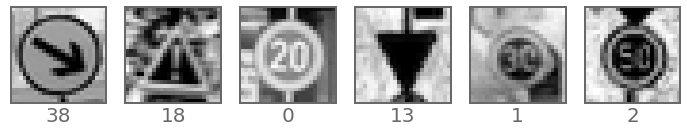

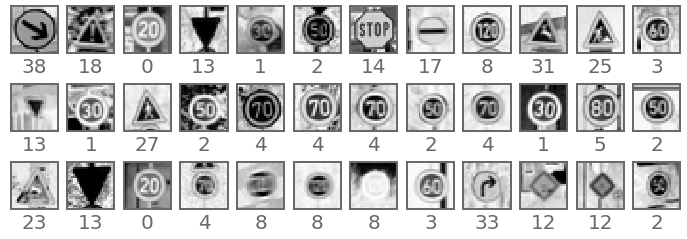

In [3]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

if img_lz>1:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(6),  columns=3,  x_size=4, y_size=3)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(36), columns=12, x_size=1, y_size=1)
else:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(6),  columns=6,  x_size=2, y_size=2)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(36), columns=12, x_size=1, y_size=1)

## 4/ Create model

In [4]:
batch_size  =  64
num_classes =  43
epochs      =  5

In [5]:
model = keras.models.Sequential()
model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(img_lx, img_ly, img_lz)))
model.add( keras.layers.MaxPooling2D((2, 2)))
model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
model.add( keras.layers.MaxPooling2D((2, 2)))
model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(3072, activation='relu'))
model.add( keras.layers.Dense(500, activation='relu'))
model.add( keras.layers.Dense(500, activation='relu'))
model.add( keras.layers.Dense(43, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 3072)              9440256   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1

## 5/ Run model

In [6]:
%%time

history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))

Train on 39209 samples, validate on 12630 samples
Epoch 1/5
39209/39209 [==============================] - 14s 354us/sample - loss: 0.9577 - accuracy: 0.7231 - val_loss: 0.4159 - val_accuracy: 0.8985
Epoch 2/5
39209/39209 [==============================] - 5s 128us/sample - loss: 0.1073 - accuracy: 0.9688 - val_loss: 0.2749 - val_accuracy: 0.9319
Epoch 3/5
39209/39209 [==============================] - 5s 132us/sample - loss: 0.0546 - accuracy: 0.9834 - val_loss: 0.2435 - val_accuracy: 0.9407
Epoch 4/5
39209/39209 [==============================] - 5s 131us/sample - loss: 0.0380 - accuracy: 0.9888 - val_loss: 0.3128 - val_accuracy: 0.9365
Epoch 5/5
39209/39209 [==============================] - 5s 132us/sample - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.3526 - val_accuracy: 0.9315
CPU times: user 40.1 s, sys: 5.03 s, total: 45.1 s
Wall time: 34.5 s


## 6/ Evaluation

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.3526
Test accuracy  : 0.9315


---
### Results :  
L25 : size=250 Mo, 93.15%  
...